In [1]:
from helpers.utilities import (
    DataFrame, Series, partial,
    T, F, pd
)
%run helpers/notebook_setup.ipynb

In [2]:
from analyses.integration.Uniform_preprocessing import (
    # data matrices
    raw_protein_matrix, raw_rna_matrix,
    clinical_union as clinical,
    # misc
    RNA_OUTLIERS,
    patients_union, patients_union_series, patients_with_both,
    # full response vectors derived from clinical data for
    # the union of patients with CSF RNA or with protein data
    protein_conditions,
    # preprocessing
    preprocess,

    # subsets of patients (uniform train-test split)
    full_cm_and_tmdr,        # CM+TMD+TMR patients with CSF RNA or protein data
    intersect_cm_and_tmdr,   # CM+TMD+TMR patients with both CSF RNA and protein data
    cm_and_tmdr_validation,  # CM+TMD+TMR patients with single omic data only
    tms_validation,          # CM patients with single omic data only + all TMS patients
)

Importing Jupyter notebook from /home/krassowski/meningitis-integration/analyses/integration/Uniform_preprocessing.ipynb


In [3]:
from sklearn.pipeline import make_pipeline
from machine_learning.repeated_cv import null_distributions_over_cv, cross_validate_and_test

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var

Loading required package: ROCR
Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess

Loading required package: data.table
 
cvAUC version: 1.1.0
Notice to cvAUC users: Major speed improvements in version 1.1.0
 


In [4]:
from plots.cm_vs_tmdr_or_tms import cm_vs_tmdr_or_tms_roc_curves

%R import::here(roc_auc_tmdr_cm, .from='plots/cm_vs_tmdr_or_tms.R')
%R import::here(plot_roc_auc, .from='plots/roc_auc.R')

In [5]:
from machine_learning.multi_block_pipeline import TwoBlockPipeline
from machine_learning.predictions import predict_proba
from machine_learning.preprocessing import ConditionsVectorizer, OutliersFilter

from utilities import subset, add_supervision_block

In [6]:
cross_validate = partial(
    cross_validate_and_test,
    response=clinical.Meningitis,
    case_class='Tuberculosis',
    use_seed=True,
    multi_scale=True,
    test_size_min=0.16,
    test_size_max=0.33,
    min_class_members=2
)

In [7]:
from sklearn.linear_model import LogisticRegressionCV

In [8]:
%%R
import::here(
    coefficients_volcano_plot, plots_most_frequently_included,
    plot_most_significant, plot_highest_magnitutude, mean_vs_coefficients,
    .from='plots/coefficients.R'
)

# Logistic regression (ridge normalization)

In [9]:
# TODO adopt
CV_REPEATS_DEMONSTRATIONS = 20
CV_REPEATS_FINAL_MODEL = 100

## Using the intersection - separate normalizations

In [10]:
from machine_learning.multi_block_pipeline import MultiBlockPipeline
from machine_learning.data_classes import BlocksWrapper
from machine_learning.combine import BlocksConcatenation
from machine_learning.adapter import SklearnAdapter
from machine_learning.utilities import Suffixer

In [11]:
def create_block_ridge_pipeline(smallest_group_n, outliers, subset=None, verbose=False, **kwargs):
    return MultiBlockPipeline(
        block_pipelines={
            'Protein': make_pipeline(
                preprocess('protein', smallest_group_n, outliers, verbose=verbose, **kwargs),
                Suffixer('.Protein')
            ),
            'RNA': make_pipeline(
                preprocess('rna', smallest_group_n, outliers, verbose=verbose, **kwargs),
                Suffixer('.RNA')
            ),
            'Meningitis': make_pipeline(
                OutliersFilter(outlier_patients=outliers, verbose=verbose),
                ConditionsVectorizer(mapping=clinical.Meningitis, case_class='Tuberculosis')
            )
        },
        combine=BlocksConcatenation(blocks=['Protein', 'RNA']),
        adapter=SklearnAdapter(Combined='X', Meningitis='y'),
        model=LogisticRegressionCV(
            penalty='l2', solver='liblinear',
            class_weight='balanced',
            max_iter=150
        ),
        predict=predict_proba
    )

In [12]:
ridge_pipeline_concat_intersect = create_block_ridge_pipeline(7, outliers=RNA_OUTLIERS)

[1] "Retaining: 99.92%"
[1] "Retaining: 52.62%"


In [13]:
train_data = (
    BlocksWrapper({
        'Protein': subset(raw_protein_matrix, intersect_cm_and_tmdr),
        'RNA': subset(raw_rna_matrix, intersect_cm_and_tmdr, outliers=RNA_OUTLIERS)
    })
    .align_indices()
    .add_supervision_block(intersect_cm_and_tmdr, name='Meningitis')
    .blocks
)

OutliersFilter: filtering out 0 outliers


In [14]:
train_data['Protein'].index.map(clinical.Meningitis).value_counts()

Cryptococcal    14
Tuberculosis    11
dtype: int64

In [15]:
train_data['RNA'].index.map(clinical.Meningitis).value_counts()

Cryptococcal    14
Tuberculosis    11
dtype: int64

The test data is only available for patients with single omics, not for patients with both omics, as this was the criteria for initial train-test split:

In [16]:
assert not set(cm_and_tmdr_validation).intersection(set(patients_with_both))

If I want to have a test set using these data, it would be degenerate with half of the data (for one or the other omic) missing. The tests could be performed twice, once with RNA missing, once with protein missing as such it would be the best to perform the tests outside of this function which allows for one test only:

In [17]:
concat_intersect_ridge = cross_validate(
    ridge_pipeline_concat_intersect,
    train_data,
    test_data=None,
    n=CV_REPEATS_FINAL_MODEL,
    coefficients={'combined': 'coef_'},
    verbose=T,
    stratify=T,
    early_normalization=False
)

Fitting cross-validation models...



Re-fitting on the entire dataset (no parameters estimated)...


### Test case 1: Use patients with Protein data only (and set missing RNA observations to zero):

In [18]:
test_protein = (
    BlocksWrapper({
        'Protein': subset(raw_protein_matrix, cm_and_tmdr_validation, outliers=RNA_OUTLIERS),
        'RNA': subset(raw_rna_matrix, cm_and_tmdr_validation, outliers=RNA_OUTLIERS)
    })
    .nullify_exclusively('RNA')
    .transform_single_block('RNA', Suffixer('.RNA'), mark=True)
    .add_supervision_block(cm_and_tmdr_validation, name='Meningitis')
)

test_protein_dataset = test_protein.to_dataset(
    case_class='Tuberculosis',
    response=clinical.Meningitis
)

OutliersFilter: filtering out 3 outliers
OutliersFilter: filtering out 6 outliers


In [19]:
protein_test_result = concat_intersect_ridge.validate(test_protein_dataset)

### Test case 2: Use patients with RNA data only (and set missing Protein observations to zero):

In [20]:
test_rna = (
    BlocksWrapper({
        'Protein': subset(raw_protein_matrix, cm_and_tmdr_validation, outliers=RNA_OUTLIERS),
        'RNA': subset(raw_rna_matrix, cm_and_tmdr_validation, outliers=RNA_OUTLIERS)
    })
    .nullify_exclusively('Protein')
    .transform_single_block('Protein', Suffixer('.Protein'), mark=True)
    .add_supervision_block(cm_and_tmdr_validation, name='Meningitis')
)

test_rna_dataset = test_rna.to_dataset(
    case_class='Tuberculosis',
    response=clinical.Meningitis
)

OutliersFilter: filtering out 3 outliers
OutliersFilter: filtering out 6 outliers


In [21]:
rna_test_result = concat_intersect_ridge.validate(test_rna_dataset)

In [22]:
rna_test_result_sub = concat_intersect_ridge.cross_validation.validate(test_rna_dataset)
protein_test_result_sub = concat_intersect_ridge.cross_validation.validate(test_protein_dataset)

In [23]:
roc_auc_concat = pd.concat([
    concat_intersect_ridge.cross_validation_results.roc_auc.assign(group='CV train: TMD+TMR vs CM', models='Cross-Validation', set='Train: TMD+TMR vs CM'),
    protein_test_result_sub.roc_auc.assign(group='Protein CV test: TMD vs CM', models='Cross-Validation', set='Train: Protein, TMD+TMR vs CM'),
    rna_test_result_sub.roc_auc.assign(group='RNA CV test: TMD vs CM', models='Cross-Validation', set='Train: RNA, TMD+TMR vs CM'),
    protein_test_result.roc_auc.assign(group='Protein full test: TMD vs CM', models='Full model', set='Test: Protein, TMD+TMR vs CM'),
    rna_test_result.roc_auc.assign(group='RNA full test: TMD vs CM', models='Full model', set='Test: RNA, TMD+TMR vs CM')
])

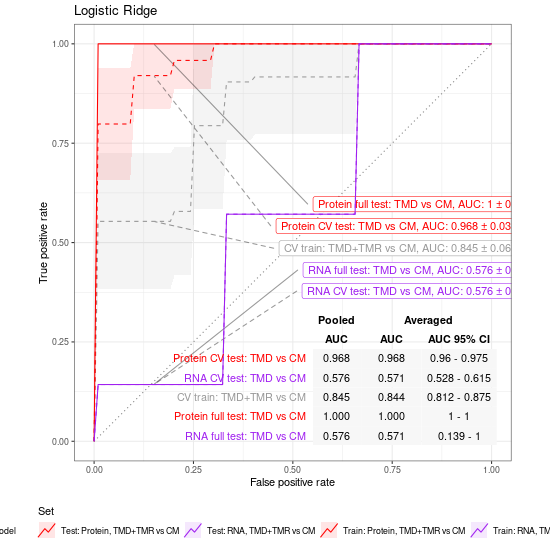

In [24]:
%%R -i roc_auc_concat -w 550 -h 550

colors = c(
    'Train: TMD+TMR vs CM'='#999999',
    'Test: Protein, TMD+TMR vs CM'='red',
    'Test: RNA, TMD+TMR vs CM'='purple',
    'Train: Protein, TMD+TMR vs CM'='red',
    'Train: RNA, TMD+TMR vs CM'='purple'
)

roc_auc_tmdr_cm(roc_auc_concat, annotation=0.15, colors=colors) + labs(title='Logistic Ridge')

Maybe ridge is unable to control both omics well with a single $\alpha$?

In [25]:
len(test_rna.blocks['RNA']), len(test_protein.blocks['Protein'])

(10, 16)

### Features driving models with high AUC

100 models were trained with two omics at once but tested on data from patients having a single omic only (either RNA or Protein). The performance of each model in both scenarios (testing with RNA or with Protein only) was averaged:

In [26]:
average_auc = (Series(protein_test_result_sub.cv_auc) + Series(rna_test_result_sub.cv_auc)) / 2
average_auc.head(3)

0    0.760714
1    0.777381
2    0.760714
dtype: float64

and the features included in the successful models (having high AUC) were visualized, weighting by the contribution strength:

In [27]:
concat_intersect_ridge.cross_validation.contributions.combined.add_weighted_auc(average_auc)
concat_intersect_ridge_contribs = concat_intersect_ridge.cross_validation.contributions.combined.data

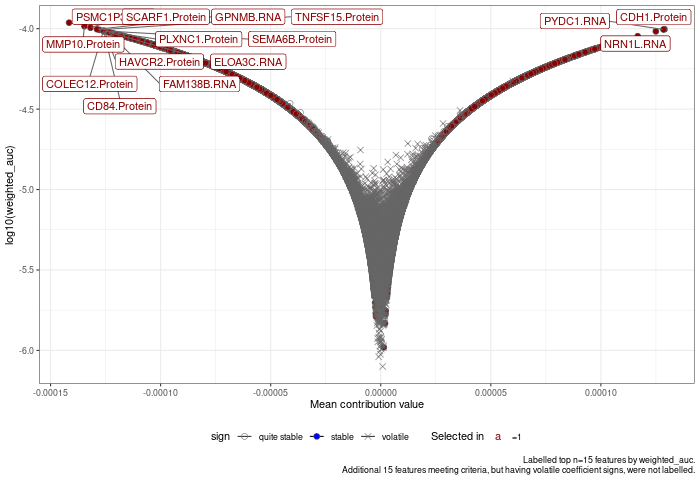

In [28]:
%%R -w 700 -i concat_intersect_ridge_contribs
coefficients_volcano_plot(
    concat_intersect_ridge_contribs,
    n=15, p_value='weighted_auc', neg=F, point_color='grey40',
    highlight_frequent=FALSE
) + ylab('Mean contribution value')

# Single omics (using the intersection to match concatenated omics)

In [35]:
from machine_learning.data_classes import MultiBlockDataSet

tms_protein_dataset = MultiBlockDataSet(
    add_supervision_block({'x': subset(raw_protein_matrix, tms_validation)}, tms_validation),
    case_class='Tuberculosis',
    response=clinical.Meningitis
)
tms_rna_dataset = MultiBlockDataSet(
    add_supervision_block(
        {'x': subset(raw_rna_matrix, tms_validation, outliers=RNA_OUTLIERS)},
        tms_validation
    ),
    case_class='Tuberculosis',
    response=clinical.Meningitis
)

OutliersFilter: filtering out 2 outliers


In [36]:
patients_with_single_omic = Series(
    list(patients_union.difference(patients_with_both))
)

In [37]:
cm_and_tmdr_validation = patients_with_single_omic[
    patients_with_single_omic.str.contains('TMR|TMD|CM')
]

In [38]:
tms_validation = pd.concat([
    patients_union_series[patients_union_series.str.contains('TMS')],
    patients_with_single_omic[patients_with_single_omic.str.contains('CM')]
])

### 2.1 Proteins

In [39]:
def create_ridge_pipeline(omic, smallest_group_n, outliers, subset=None, verbose=False, **kwargs):

    return TwoBlockPipeline(
        x=preprocess(omic, smallest_group_n, outliers, verbose=verbose, **kwargs),
        y=make_pipeline(
            OutliersFilter(outlier_patients=outliers, verbose=verbose),
            ConditionsVectorizer(mapping=clinical.Meningitis, case_class='Tuberculosis')
        ),
        model=LogisticRegressionCV(
            penalty='l2', solver='liblinear',
            class_weight='balanced',
            max_iter=150
        ),
        predict=predict_proba
    )

In [40]:
ridge_pipeline_intersection_protein = create_ridge_pipeline(
    'protein',
    smallest_group_n=7,
    subset=intersect_cm_and_tmdr,
    outliers=None,
    verbose=False
)

[1] "Retaining: 99.92%"


In [41]:
intersect_protein_ridge = cross_validate(
    ridge_pipeline_intersection_protein,
    add_supervision_block(
        {'x': subset(raw_protein_matrix, intersect_cm_and_tmdr)},
        intersect_cm_and_tmdr
    ),
    test_data=add_supervision_block(
        {'x': subset(raw_protein_matrix, cm_and_tmdr_validation)},
        cm_and_tmdr_validation
    ),
    n=100,
    verbose=F,
    stratify=T,
    early_normalization=False
)

In [42]:
ridge_pipeline_intersection_rna = create_ridge_pipeline(
    'rna',
    smallest_group_n=7,
    subset=intersect_cm_and_tmdr,
    outliers=RNA_OUTLIERS,
    verbose=False
)

[1] "Retaining: 52.62%"


In [43]:
intersect_rna_ridge = cross_validate(
    ridge_pipeline_intersection_rna,
    add_supervision_block(
        {'x': subset(raw_rna_matrix, intersect_cm_and_tmdr, outliers=RNA_OUTLIERS)},
        intersect_cm_and_tmdr
    ),
    test_data=add_supervision_block(
        {'x': subset(raw_rna_matrix, cm_and_tmdr_validation, outliers=RNA_OUTLIERS)},
        cm_and_tmdr_validation
    ),
    n=20,
    verbose=F,
    stratify=T,
    early_normalization=False
)

OutliersFilter: filtering out 0 outliers
OutliersFilter: filtering out 6 outliers


# Enrichment comparison

In [44]:
import analyses.integration.Pathway_enrichment
%R import::here(camera_pr, .from='helpers/pathways.R')

Importing Jupyter notebook from /home/krassowski/meningitis-integration/analyses/integration/Pathway_enrichment.ipynb


/home/krassowski/.pyenv/versions/3.7.6/envs/meningitis/lib/python3.7/site-packages/gsea_api/molecular_signatures_db.py:65: UserWarning: Provided gene sets are not redundant; there are 117 gene sets having more than one name assigned; use `find_redundant()` to investigate further.
  warn(message)
/home/krassowski/.pyenv/versions/3.7.6/envs/meningitis/lib/python3.7/site-packages/gsea_api/molecular_signatures_db.py:65: UserWarning: Provided gene sets are not redundant; there are 40 gene sets having more than one name assigned; use `find_redundant()` to investigate further.
  warn(message)


hallmarks 50
hallmarks_for_rna 50
hallmarks_for_protein 49
reactome 1431


/home/krassowski/.pyenv/versions/3.7.6/envs/meningitis/lib/python3.7/site-packages/gsea_api/molecular_signatures_db.py:65: UserWarning: Provided gene sets are not redundant; following gene sets are identical: 'Telomere Maintenance' and 'Extension of Telomeres' (44 genes)
  warn(message)


reactome_for_rna 1430
reactome_for_protein 581


/home/krassowski/.pyenv/versions/3.7.6/envs/meningitis/lib/python3.7/site-packages/gsea_api/molecular_signatures_db.py:65: UserWarning: Provided gene sets are not redundant; there are 104 gene sets having more than one name assigned; use `find_redundant()` to investigate further.
  warn(message)
/home/krassowski/.pyenv/versions/3.7.6/envs/meningitis/lib/python3.7/site-packages/gsea_api/molecular_signatures_db.py:75: UserWarning: There are 281 empty gene sets: use `empty_gene_sets` property to investigate further.
  warn(f'There are {len(empty_gene_sets)} empty gene sets: {empty_message}')
/home/krassowski/.pyenv/versions/3.7.6/envs/meningitis/lib/python3.7/site-packages/gsea_api/molecular_signatures_db.py:79: UserWarning: 281 empty gene sets were removed.
  warn(f'{len(empty_gene_sets)} empty gene sets were removed.')


General picture of meningitis, not related to disease etiology and indifferent to the method in use, as discoverable when using observed subset of transcripts/proteins:

In [45]:
single_ridge_contribs_rna = intersect_rna_ridge.cross_validation.contributions.x.data
single_ridge_contribs_protein = intersect_protein_ridge.cross_validation.contributions.x.data

In [46]:
%R -i single_ridge_contribs_rna -i single_ridge_contribs_protein

In [47]:
%R camera_pr(single_ridge_contribs_protein, 'mean_abundance', hallmarks_for_protein)

[1] "Removed 2 NAs"


,NGenes,Direction,PValue,FDR
OXIDATIVE PHOSPHORYLATION,9.0,Down,0.000010,0.000477
UNFOLDED PROTEIN RESPONSE,8.0,Up,0.045211,0.999055
ESTROGEN RESPONSE LATE,31.0,Down,0.114043,0.999055
HYPOXIA,46.0,Up,0.161131,0.999055
INTERFERON ALPHA RESPONSE,13.0,Down,0.168909,0.999055
...,...,...,...,...
UV RESPONSE UP,26.0,Up,0.938355,0.999055
TGF BETA SIGNALING,11.0,Down,0.960442,0.999055
INTERFERON GAMMA RESPONSE,47.0,Up,0.984216,0.999055
TNFA SIGNALING VIA NFKB,54.0,Down,0.991590,0.999055


In [48]:
%R camera_pr(single_ridge_contribs_rna, 'mean_abundance', hallmarks_for_rna)

[1] "Removed 47 NAs"


,NGenes,Direction,PValue,FDR
NOTCH SIGNALING,32.0,Up,0.008578,0.428921
APICAL SURFACE,43.0,Up,0.053016,0.739844
TGF BETA SIGNALING,54.0,Up,0.054980,0.739844
MTORC1 SIGNALING,197.0,Up,0.068258,0.739844
INTERFERON ALPHA RESPONSE,96.0,Up,0.073984,0.739844
...,...,...,...,...
PROTEIN SECRETION,95.0,Down,0.925800,0.985050
SPERMATOGENESIS,120.0,Up,0.937959,0.985050
COAGULATION,128.0,Up,0.945648,0.985050
PANCREAS BETA CELLS,37.0,Down,0.971324,0.991147


Naive group differences (should not be taken too seriously, the difference metric is known to be weak), supervised:

In [49]:
def get_diff(data, group_a, group_b, func=lambda a, b: a - b):
    a = data[data.index.str.contains(group_a)].mean()
    b = data[data.index.str.contains(group_b)].mean()
    return func(a, b).to_frame('diff')

In [50]:
protein_full = preprocess('protein', 7, None).fit_transform(raw_protein_matrix.T)
rna_full = preprocess('rna', 7, None).fit_transform(raw_rna_matrix.T)

[1] "Retaining: 99.92%"
[1] "Retaining: 52.62%"


In [51]:
protein_diff = get_diff(protein_full, 'TMD|TMR', 'CM')
rna_diff = get_diff(rna_full, 'TMD|TMR', 'CM')
protein_diff.head()

,diff
STUB1,0.629198
CEBPB,0.596851
ENO2,-0.478050
PIAS4,0.433054
IL10RA,-0.731442


In [52]:
%R -i protein_diff -i rna_diff

In [53]:
ridge_combined = concat_intersect_ridge.cross_validation.contributions.combined.data
ridge_combined

,mean,selected_in,positive_in,negative_in,volatile,stdev,ci,mean_abundance,gene,weighted_auc
STUB1.Protein,-0.000050,1.0,0.00,1.00,0.0,0.000016,1.754212e-07,1.548761e-14,STUB1.Protein,0.000038
CEBPB.Protein,0.000045,1.0,1.00,0.00,0.0,0.000005,5.072197e-08,7.993606e-15,CEBPB.Protein,0.000035
ENO2.Protein,0.000005,1.0,0.95,0.05,0.1,0.000004,3.929586e-08,6.517009e-14,ENO2.Protein,0.000004
PIAS4.Protein,0.000026,1.0,1.00,0.00,0.0,0.000008,8.499567e-08,-6.439294e-15,PIAS4.Protein,0.000020
IL10RA.Protein,-0.000024,1.0,0.00,1.00,0.0,0.000003,3.699591e-08,3.624878e-14,IL10RA.Protein,0.000018
...,...,...,...,...,...,...,...,...,...,...
RPL6P12.RNA,0.000066,1.0,0.25,0.00,0.0,0.000000,0.000000e+00,NaN,RPL6P12.RNA,NaN
TCEANC2.RNA,-0.000027,1.0,0.00,0.22,0.0,0.000000,0.000000e+00,NaN,TCEANC2.RNA,NaN
GTF3C4.RNA,-0.000036,1.0,0.00,0.22,0.0,0.000000,0.000000e+00,-2.753353e-14,GTF3C4.RNA,NaN
SEM1.RNA,-0.000073,1.0,0.00,0.22,0.0,0.000000,0.000000e+00,NaN,SEM1.RNA,NaN


In [54]:
ridge_combined_rna = ridge_combined[ridge_combined.index.str.endswith('RNA')].copy()
ridge_combined_rna.index = ridge_combined_rna.index.str[:-4]
ridge_combined_rna

,mean,selected_in,positive_in,negative_in,volatile,stdev,ci,mean_abundance,gene,weighted_auc
TSPAN6,-0.000007,1.0,0.22,0.78,0.44,0.000010,1.043837e-07,-1.110223e-15,TSPAN6.RNA,0.000008
DPM1,-0.000002,1.0,0.52,0.48,0.96,0.000008,8.258927e-08,2.109424e-15,DPM1.RNA,0.000005
SCYL3,-0.000004,1.0,0.00,1.00,0.00,0.000003,3.373104e-08,3.338996e-14,SCYL3.RNA,0.000003
C1orf112,0.000066,1.0,1.00,0.00,0.00,0.000004,3.845826e-08,1.182388e-14,C1orf112.RNA,0.000051
FGR,0.000024,1.0,1.00,0.00,0.00,0.000008,9.001073e-08,-1.221245e-14,FGR.RNA,0.000018
...,...,...,...,...,...,...,...,...,...,...
RPL6P12,0.000066,1.0,0.25,0.00,0.00,0.000000,0.000000e+00,NaN,RPL6P12.RNA,NaN
TCEANC2,-0.000027,1.0,0.00,0.22,0.00,0.000000,0.000000e+00,NaN,TCEANC2.RNA,NaN
GTF3C4,-0.000036,1.0,0.00,0.22,0.00,0.000000,0.000000e+00,-2.753353e-14,GTF3C4.RNA,NaN
SEM1,-0.000073,1.0,0.00,0.22,0.00,0.000000,0.000000e+00,NaN,SEM1.RNA,NaN


In [55]:
ridge_combined_protein = ridge_combined[ridge_combined.index.str.endswith('Protein')].copy()
ridge_combined_protein.index = ridge_combined_protein.index.str[:-8]
ridge_combined_protein

,mean,selected_in,positive_in,negative_in,volatile,stdev,ci,mean_abundance,gene,weighted_auc
STUB1,-0.000050,1.0,0.00,1.00,0.00,1.598607e-05,1.754212e-07,1.548761e-14,STUB1.Protein,0.000038
CEBPB,0.000045,1.0,1.00,0.00,0.00,4.622275e-06,5.072197e-08,7.993606e-15,CEBPB.Protein,0.000035
ENO2,0.000005,1.0,0.95,0.05,0.10,3.581018e-06,3.929586e-08,6.517009e-14,ENO2.Protein,0.000004
PIAS4,0.000026,1.0,1.00,0.00,0.00,7.745626e-06,8.499567e-08,-6.439294e-15,PIAS4.Protein,0.000020
IL10RA,-0.000024,1.0,0.00,1.00,0.00,3.371424e-06,3.699591e-08,3.624878e-14,IL10RA.Protein,0.000018
...,...,...,...,...,...,...,...,...,...,...
FTCD,0.000006,1.0,0.73,0.27,0.54,6.299873e-06,6.913088e-08,1.762479e-14,FTCD.Protein,0.000005
USP25,0.000015,1.0,1.00,0.00,0.00,4.531563e-06,4.972655e-08,1.340594e-14,USP25.Protein,0.000011
PLXNB2,0.000004,1.0,0.70,0.30,0.60,9.824678e-06,1.078099e-07,6.214473e-14,PLXNB2.Protein,0.000007
SCGB2A1,0.000023,1.0,0.25,0.00,0.00,3.457998e-21,3.794591e-23,NaN,SCGB2A1.Protein,NaN


In [58]:
%%R
import::here(contributions_pathways, base_contributions_pathways, .from='helpers/pathways.R')

top_n = 10
# these are based on the abundance difference
protein = head(camera_pr(protein_diff, 'diff', hallmarks_for_protein), top_n)
RNA = head(camera_pr(rna_diff, 'diff', hallmarks_for_rna), top_n)

rna_label = 'RNA (abundance difference)'
protein_label = 'Protein (abundance difference)'


# these are based on the protein/RNA contributions
ridge_combined_protein_label = 'Mean of contributions concat Ridge (proteins)'
ridge_combined_rna_label = 'Mean of contributions concat Ridge (RNA)'
ridge_protein_label = 'Mean of contributions Ridge (proteins)'
ridge_rna_label = 'Mean of contributions Ridge (RNA)'



RNA = base_contributions_pathways(RNA, rna_label)
protein = base_contributions_pathways(protein, protein_label)


ridge_protein_relative_to_mean = contributions_pathways(
    head(camera_pr(single_ridge_contribs_protein, 'mean', hallmarks_for_protein), top_n),
    label=ridge_protein_label,
    RNA, protein,
    rna_label, protein_label
)

ridge_rna_relative_to_mean = contributions_pathways(
    head(camera_pr(single_ridge_contribs_rna, 'mean', hallmarks_for_rna), top_n),
    label=ridge_rna_label,
    RNA, protein,
    rna_label, protein_label
)

In [59]:
%%R -i ridge_combined_protein -i ridge_combined_rna


ridge_protein = base_contributions_pathways(
    head(camera_pr(single_ridge_contribs_protein, 'mean', hallmarks_for_protein), top_n),
    ridge_protein_label
)

ridge_rna = base_contributions_pathways(
    head(camera_pr(single_ridge_contribs_rna, 'mean', hallmarks_for_rna), top_n),
    ridge_rna_label
)

ridge_combined_protein = contributions_pathways(
    head(camera_pr(ridge_combined_protein, 'mean', hallmarks_for_protein), top_n),
    label=ridge_combined_protein_label,
    ridge_rna, ridge_protein,
    ridge_rna_label, ridge_protein_label
)

ridge_combined_rna = contributions_pathways(
    head(camera_pr(ridge_combined_rna, 'mean', hallmarks_for_rna), top_n),
    label=ridge_combined_rna_label,
    ridge_rna, ridge_protein,
    ridge_rna_label, ridge_protein_label
)

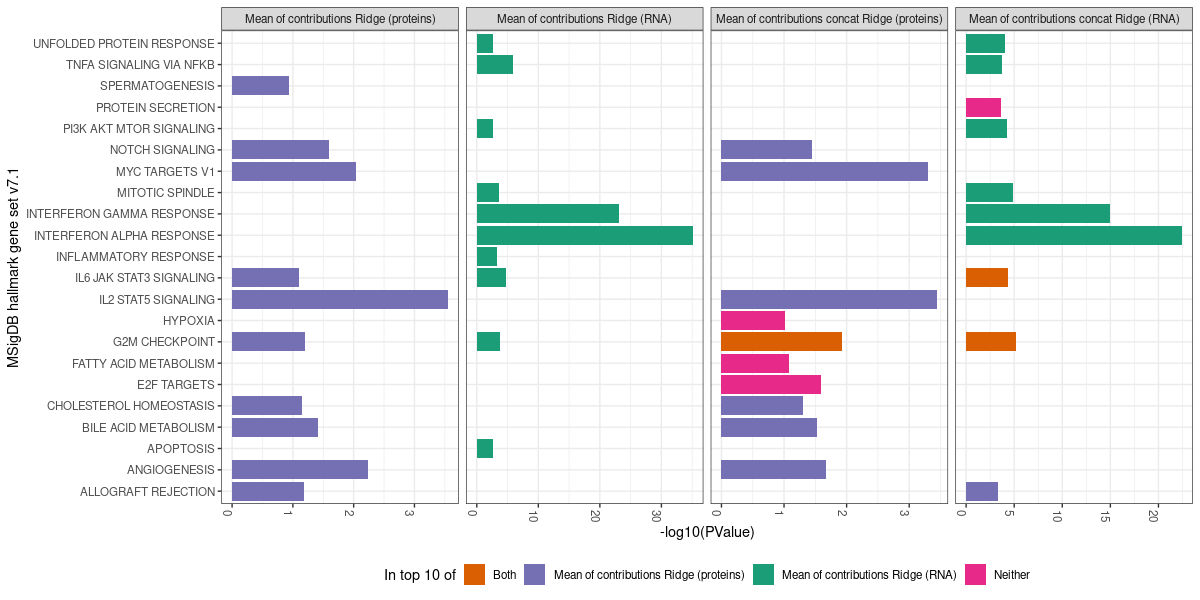

In [60]:
%%R -w 1200 -r 95 -h 600

pathway_colors = c('#D95F02', '#E7298A', '#7570B3', '#1B9E77')
names(pathway_colors) = c('Both', 'Neither', ridge_protein_label, ridge_rna_label)

df = rbind(ridge_protein, ridge_rna, ridge_combined_protein, ridge_combined_rna)
df$kind = factor(
    df$kind,
    levels=c(ridge_protein_label, ridge_rna_label, ridge_combined_protein_label, ridge_combined_rna_label)
)


(
    ggplot(df, aes(x=gene, y=-log10(PValue), fill=from))
    + geom_bar(stat='identity')
    + facet_wrap('kind', scale='free_x', ncol=5)
    + nice_theme
    + theme(axis.text.x=element_text(angle = -90, hjust = 0))
    + coord_flip()
    + scale_fill_manual(name='In top 10 of', values=pathway_colors)
    + xlab('MSigDB hallmark gene set v7.1')
)

# TODO: head on the dataset before visualisation removes important information; should have all in and then set breaks to only show top pathways (current head's function); or significance criterion? What is "both" really?

In [61]:
%%R -i ridge_combined_protein -i ridge_combined_rna
top_n = 15

ridge_protein = base_contributions_pathways(
    head(camera_pr(single_ridge_contribs_protein, 'mean', reactome_for_protein), top_n),
    ridge_protein_label
)

ridge_rna = base_contributions_pathways(
    head(camera_pr(single_ridge_contribs_rna, 'mean', reactome_for_rna), top_n),
    ridge_rna_label
)


ridge_combined_protein = contributions_pathways(
    head(camera_pr(ridge_combined_protein, 'mean', reactome_for_protein), top_n),
    label=ridge_combined_protein_label,
    ridge_rna, ridge_protein,
    ridge_rna_label, ridge_protein_label
)

ridge_combined_rna = contributions_pathways(
    head(camera_pr(ridge_combined_rna, 'mean', reactome_for_rna), top_n),
    label=ridge_combined_rna_label,
    ridge_rna, ridge_protein,
    ridge_rna_label, ridge_protein_label
)

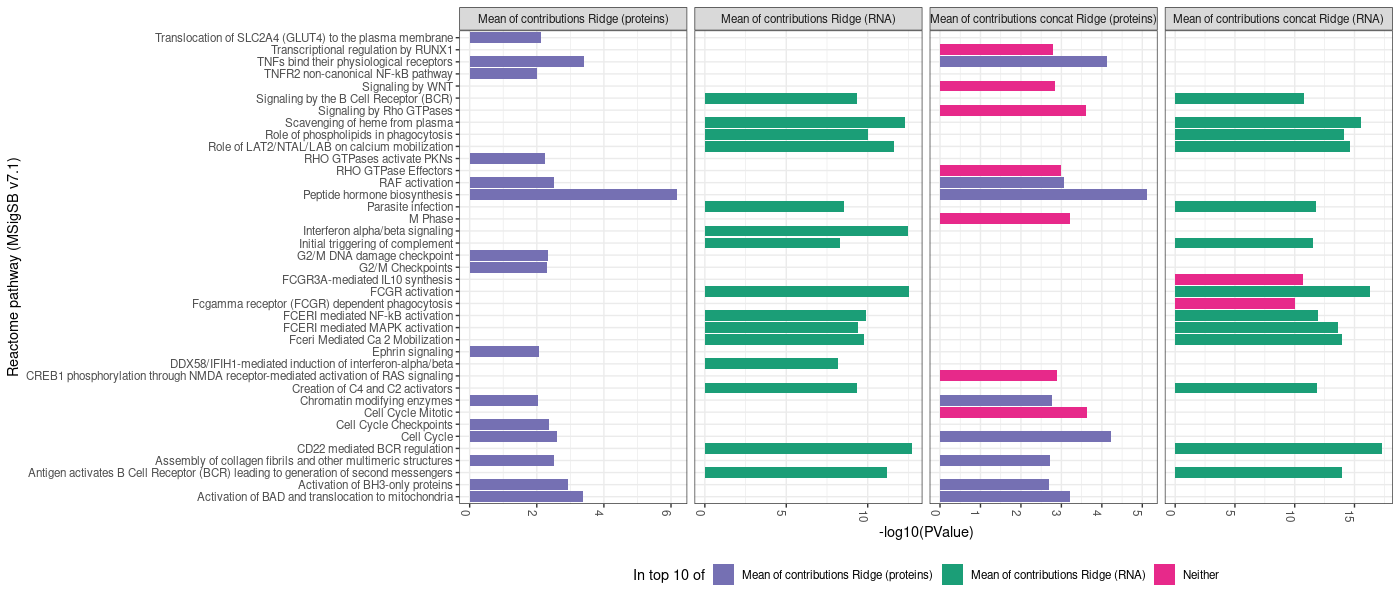

In [62]:
%%R -w 1400 -r 95 -h 600
df = rbind(ridge_protein, ridge_rna, ridge_combined_protein, ridge_combined_rna)
df$kind = factor(df$kind, levels=c(ridge_protein_label, ridge_rna_label, ridge_combined_protein_label, ridge_combined_rna_label))

(
    ggplot(df, aes(x=gene, y=-log10(PValue), fill=from))
    + geom_bar(stat='identity')
    + facet_wrap('kind', scale='free_x', ncol=5)
    + nice_theme
    + theme(axis.text.x=element_text(angle = -90, hjust = 0))
    + coord_flip()
    + scale_fill_manual(name='In top 10 of', values=pathway_colors)
    + xlab('Reactome pathway (MSigSB v7.1)')
)

- after concatenation, the chosen pathways are very different between RNA and proteins
- even though if we trained on individual omics, we would get an overlap
- this is because in concatenated model we get competition (two correlated variables such as corresponding RNA-protein pair will not be chosen twice)!
  - but if we get "both" (as in hallmarks) does it mean anything special?
  - yes, that both RNA and protein demonstrate this signal and neither is stronger
    - on the other hand if a pathway appear boosted in only omic, it probably has stronger signal for it...

In [63]:
%R -i ridge_combined_rna -i ridge_combined_protein

In [64]:
%R head(camera_pr(ridge_combined_protein, 'mean', reactome_for_protein), 10)

,NGenes,Direction,PValue,FDR
Peptide hormone biosynthesis,7.0,Down,0.000008,0.004389
Cell Cycle,64.0,Up,0.000059,0.014318
TNFs bind their physiological receptors,25.0,Down,0.000074,0.014318
Cell Cycle Mitotic,54.0,Up,0.000234,0.028899
Signaling by Rho GTPases,38.0,Up,0.000249,0.028899
M Phase,38.0,Up,0.000623,0.052090
Activation of BAD and translocation to mitochondria,10.0,Up,0.000628,0.052090
RAF activation,9.0,Up,0.000861,0.062562
RHO GTPase Effectors,34.0,Up,0.001036,0.066910
CREB1 phosphorylation through NMDA receptor-mediated activation of RAS signaling,8.0,Up,0.001282,0.074023


In [65]:
%R head(camera_pr(ridge_combined_protein, 'weighted_auc', reactome_for_protein), 10)

[1] "Removed 4 NAs"


,NGenes,Direction,PValue,FDR
Peptide hormone biosynthesis,7.0,Up,0.000092,0.053252
TFAP2 (AP-2) family regulates transcription of growth factors and their receptors,6.0,Up,0.004329,0.835113
Transcriptional regulation of granulopoiesis,7.0,Up,0.011005,0.835113
DAP12 interactions,13.0,Down,0.015482,0.835113
Regulation of Insulin-like Growth Factor (IGF) transport and uptake by Insulin-like Growth Factor Binding Proteins (IGFBPs),55.0,Down,0.017281,0.835113
Pre-NOTCH Expression and Processing,8.0,Up,0.017701,0.835113
Response To Elevated Platelet Cytosolic Ca2,57.0,Down,0.022461,0.835113
Opioid Signalling,15.0,Up,0.025470,0.835113
TNFs bind their physiological receptors,25.0,Up,0.029104,0.835113
DAP12 signaling,10.0,Down,0.030144,0.835113


#### RNA

In [66]:
%R head(camera_pr(ridge_combined_rna, 'mean', reactome_for_rna), 10)

,NGenes,Direction,PValue,FDR
CD22 mediated BCR regulation,53.0,Up,4.614105e-18,6.598171e-15
FCGR activation,61.0,Up,4.652650e-17,3.326645e-14
Scavenging of heme from plasma,60.0,Up,2.899889e-16,1.382280e-13
Role of LAT2/NTAL/LAB on calcium mobilization,62.0,Up,2.160690e-15,7.724465e-13
Role of phospholipids in phagocytosis,73.0,Up,7.164555e-15,2.049063e-12
Fceri Mediated Ca 2 Mobilization,77.0,Up,1.032142e-14,2.154251e-12
Antigen activates B Cell Receptor (BCR) leading to generation of second messengers,78.0,Up,1.054529e-14,2.154251e-12
FCERI mediated MAPK activation,78.0,Up,2.461968e-14,4.400769e-12
FCERI mediated NF-kB activation,126.0,Up,1.090138e-12,1.732108e-10
Creation of C4 and C2 activators,62.0,Up,1.319597e-12,1.887024e-10


In [67]:
%R head(camera_pr(ridge_combined_rna, 'weighted_auc', reactome_for_rna), 10)

[1] "Removed 534 NAs"


,NGenes,Direction,PValue,FDR
Scavenging of heme from plasma,60.0,Up,1.171092e-08,0.000017
CD22 mediated BCR regulation,53.0,Up,4.309678e-07,0.000308
Creation of C4 and C2 activators,62.0,Up,1.237880e-06,0.000487
Binding and Uptake of Ligands by Scavenger Receptors,87.0,Up,1.361597e-06,0.000487
Initial triggering of complement,70.0,Up,2.708428e-06,0.000775
SRP-dependent cotranslational protein targeting to membrane,112.0,Down,9.821469e-06,0.002341
Eukaryotic Translation Elongation,92.0,Down,1.286424e-05,0.002628
FCGR activation,61.0,Up,2.629412e-05,0.004700
Eukaryotic Translation Initiation,119.0,Down,3.977425e-05,0.006320
Interferon alpha/beta signaling,68.0,Up,6.019571e-05,0.008608
